In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from utils import imread
from drawBlobs import drawBlobs
import numpy as np
from skimage.color import rgb2gray
from scipy.ndimage import gaussian_laplace
from scipy.ndimage.filters import convolve, generic_filter
import matplotlib.pyplot as plt
import sys
%matplotlib inline

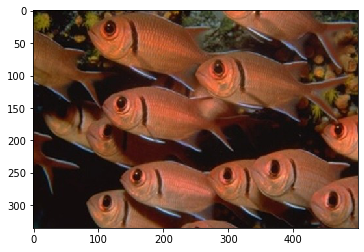

In [2]:
imgs = ['butterfly.jpg', 'einstein.jpg', 'fishes.jpg', 'sunflowers.jpg']
imageName = imgs[2]
numBlobsToDraw = 500
imName = imageName.split('.')[0]
datadir = os.path.join('..', 'data', 'blobs')
im = imread(os.path.join(datadir, imageName))
plt.imshow(im, cmap='gray')

In [3]:
def py_im2double(img):
    grayscaled = rgb2gray(img)
    original_img = grayscaled.astype('float')
    img_min, img_max = np.min(original_img.ravel()), np.max(original_img.ravel())
    return (original_img - img_min) / (img_max - img_min)

def laplacian_of_gaussian_filter(sigma):
    kernel_size = np.round(5*sigma)#np.round(6*sigma)
    if kernel_size % 2 == 0:
        kernel_size+=1
    half_size=np.floor(kernel_size/2)
    x, y = np.meshgrid(np.arange(-half_size, half_size+1), np.arange(-half_size, half_size+1))
    
    exp_term=np.exp(-(x**2+y**2) / (2*sigma**2))
    exp_term[exp_term < sys.float_info.epsilon * exp_term.max()] = 0
    if exp_term.sum() != 0:
        exp_term = exp_term/exp_term.sum() 
    else: 
        exp_term
    kernel = -((x**2 + y**2 - (2*sigma**2)) / sigma**2) * exp_term 
    kernel=kernel-kernel.mean()
    return kernel

def create_scale_space(gray_image,sigma_scale_factor,initial_sigma,level):
    h,w=np.shape(gray_image)
    scale_space = np.zeros((h,w,level),np.float32)
    sigma = [0]*(level+1)
    sigma[0] = initial_sigma
    for i in range(level):
        print('Convolving with sigma={}'.format(sigma[i]))
        kernel=laplacian_of_gaussian_filter(sigma[i])
        convolved_image=convolve(gray_image,kernel)
        #cv2.imshow("LoG Convolved Image with sigma={}".format(sigma[i]),convolved_image)
        scale_space[:,:,i] = np.square(convolved_image)
        sigma[i+1]=sigma[i]*sigma_scale_factor
    return scale_space,sigma

In [4]:
def max_scaled_spaces(scale_spaces, i, j, l1, l2):
    h, w = scale_spaces[:, :, 0].shape
    search_over = [(0, 1), (0, -1), (1, 1), (1, -1), (-1, 1), (-1, -1), (1, 0), (-1, 0)]
    flag = True
    for _i, _j in search_over:
        if (i+_i in range(h)) and (j+_j in range(w)):
            if scale_spaces[i+_i, j+_j, l2] >= scale_spaces[i, j, l1]:
                flag = False    
    return flag

def non_max_suppression_blobs(scale_spaces, scaling, sigma, level_, cutoff=0.003):
    scale_spaces_max = scale_spaces.copy()
    h, w = scale_spaces_max[:, :, 0].shape
    kernel = [int(np.ceil(s)) for s in sigma]
    blob_location = []
    for le in range(0, level_):
        curr = kernel[le]
        print ("Iterating for Level={}".format(le))
        scale_spaces_max[-curr:, -curr:, le] = 0
        scale_spaces_max[:curr, :curr, le] = 0
        for i in range(curr+1, (h - curr - 1)):
            for j in range(curr+1, (w - curr - 1)):
                if scale_spaces[i, j, le] < cutoff:
                    continue
                curr_flag = max_scaled_spaces(scale_spaces, i, j, le, le)
                lower_flag = (le > 0) and scale_spaces[i, j, le-1] < scale_spaces[i, j, le] and max_scaled_spaces(scale_spaces, i, j, le, le-1)
                upper_flag = (le < level_-1) and scale_spaces[i, j, le+1] < scale_spaces[i, j, le]  and max_scaled_spaces(scale_spaces, i, j, le, le+1) 
                
                if curr_flag and lower_flag and upper_flag: #and lower_flag
                    blob_location.append([i, j, le, scale_spaces[i, j, le]])
                    scale_spaces_max[i, j, le] = 1
                    
    return blob_location           

In [11]:
processed_im = py_im2double(rgb2gray(im))
scaling = np.sqrt(1.8)
sigma_seed = 1.2
level = 13
scale_spaces, sigma = create_scale_space(processed_im, scaling, sigma_seed, level)
#create_scale_space(gray_image,sigma_scale_factor,initial_sigma,level)
blobs = non_max_suppression_blobs(scale_spaces, scaling, sigma, level, .005)

Convolving with sigma=1.2
Convolving with sigma=1.6099689437998486
Convolving with sigma=2.16
Convolving with sigma=2.897944098839728
Convolving with sigma=3.8880000000000003
Convolving with sigma=5.21629937791151
Convolving with sigma=6.998400000000001
Convolving with sigma=9.389338880240718
Convolving with sigma=12.597120000000002
Convolving with sigma=16.900809984433295
Convolving with sigma=22.674816000000007
Convolving with sigma=30.421457971979933
Convolving with sigma=40.814668800000014
Iterating for Level=0
Iterating for Level=1
Iterating for Level=2
Iterating for Level=3
Iterating for Level=4
Iterating for Level=5
Iterating for Level=6
Iterating for Level=7
Iterating for Level=8
Iterating for Level=9
Iterating for Level=10
Iterating for Level=11
Iterating for Level=12


1147


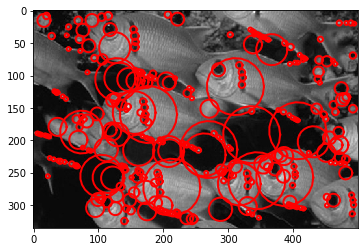

In [12]:
blob_location = blobs
print (len(blob_location))
blobs = np.zeros((len(blob_location), 5))
i = 0
for center in blob_location:
    x, y = center[0], center[1]
    radius = int(np.ceil(np.sqrt(2)*sigma[center[2]])) 
    score = center[3]
    blobs[i] = [y, x, radius, -1, score] #(x, y, radius, angle, score)
    i+=1
drawBlobs(im, blobs[:, [0, 1, 2, 4]], 300)

In [ ]:
processed_im = py_im2double(rgb2gray(im))
initial_sigma = 1.2 #1.6
k = np.sqrt(2) #initial_scale
sigma_scale_factor = np.sqrt(1.8)
level = 10
threshold_factor = .001
h, w = processed_im.shape
scale_space = np.zeros((h, w, level))
scale_space, sigma = create_scale_space(processed_im,sigma_scale_factor, initial_sigma,level)
max_scale_space = np.copy(scale_space)
mask = [0] * (level)
index = [(1, 0), (-1, 0), (0, 1), (0, -1), 
         (1, 1), (1, -1), (-1, 1), (-1, -1)]
for i in range(0, level):
    mask[i]=int(np.ceil(np.sqrt(2)*sigma[i]))
size = np.shape(scale_space[:,:,0])


In [ ]:
print (len(blob_location))
blobs = np.zeros((len(blob_location), 5))
i = 0
for center in blob_location:
    x, y = center[0], center[1]
    radius = int(np.ceil(np.sqrt(2)*sigma[center[2]])) 
    score = center[3]
    blobs[i] = [y, x, radius, -1, score] #(x, y, radius, angle, score)
    i+=1
drawBlobs(im, blobs[:, [0, 1, 2, 4]], 300)

In [ ]:
def non_max_suppression_blobs(scale_spaces, scaling, sigma, level_, cutoff=0.003):
    scale_spaces_max = scale_spaces.copy()
    h, w = scale_spaces_max[:, :, 0].shape
    blob_location = []
    kernel = [int(np.ceil(s)) for s in sigma] #int(np.ceil(s)) int(np.ceil(np.sqrt(2)*sigma[i]))
    print (kernel)
    
    
    for le in range(0, level_):
        print ("Iterating for Level={}".format(le))
        curr = kernel[le]
        scale_spaces_max[-curr:, -curr:, le] = 0
        scale_spaces_max[:curr, :curr, le] = 0
        for i in range(curr+1, (h - curr - 1)):
            for j in range(curr+1, (w - curr - 1)):
                
                if scale_spaces[i, j, le] < cutoff:
                    continue
                    
                curr_flag = max_scaled_spaces(scale_spaces, i, j, le, le)

                lower_flag = (le > 0) and scale_spaces[i, j, le-1] < scale_spaces[i, j, le] and max_scaled_spaces(scale_spaces, i, j, le, le-1)

                
#                 if le > 3 and check(le) :
#                     print ((le > 0), check(le-1) )
                
                upper_flag = (le < level_-1) and scale_spaces[i, j, le+1] < scale_spaces[i, j, le]  and max_scaled_spaces(scale_spaces, i, j, le, le+1) 
                
                #print (curr_flag, lower_flag, upper_flag)
                if curr_flag  and upper_flag: #and lower_flag
#                     if (le > 3):
#                         x1, x2, x3 = (le > 0), (scale_spaces_max[i, j, le-1] < scale_spaces_max[i, j, le]), (max_scaled_spaces(scale_spaces_max, i, j, le, le-1))
#                         m1 = x1 and x2 and x3
#                         print (lower_flag, x1, x2, x3, m1)
                    #print ("HI")
                    blob_location.append([i, j, le, scale_spaces[i, j, le]])
                    scale_spaces_max[i, j, le] = 1

In [ ]:
blobs = np.zeros((len(blob_location), 5))
i = 0
for center in blob_location:
    x, y = center[0], center[1]
    radius = int(np.ceil(np.sqrt(2)*sigma[center[2]])) 
    score = center[3]
    blobs[i] = [y, x, radius, -1, score] #(x, y, radius, angle, score)
    i+=1

In [ ]:
blob_location2 = blob_location

In [ ]:
np.testing.assert_almost_equal(blob_location1, blob_location2)

In [ ]:
blobs = np.zeros((len(blob_location), 5))
i = 0
for center in blob_location:
    x, y = center[0], center[1]
    radius = int(np.ceil(np.sqrt(2)*sigma[center[2]])) 
    score = center[3]
    blobs[i] = [y, x, radius, -1, score] #(x, y, radius, angle, score)
    i+=1

In [ ]:
drawBlobs(im, blobs[:, [0, 1, 2, 4]], 300)

In [ ]:
blob_location1 = blob_location

In [ ]:
len(blob_location1)

In [ ]:
# Working ..., 
processed_im = py_im2double(rgb2gray(im))
initial_sigma = 1.2 #1.6
k = np.sqrt(2) #initial_scale
sigma_scale_factor = np.sqrt(1.8)
level = 10
threshold_factor = .001
h, w = processed_im.shape
scale_space = np.zeros((h, w, level))
scale_space, sigma = create_scale_space(processed_im,sigma_scale_factor, initial_sigma,level)
max_scale_space = np.copy(scale_space)
mask = [0] * (level)
index = [(1, 0), (-1, 0), (0, 1), (0, -1), 
         (1, 1), (1, -1), (-1, 1), (-1, -1)]
for i in range(0, level):
    mask[i]=int(np.ceil(np.sqrt(2)*sigma[i]))
size = np.shape(scale_space[:,:,0])

# def check(l):
#     return all(scale_space[i + dx, j + dy, l] < scale_space[i, j, k] 
#        for dx, dy in index 
#        if  0<= i + dx < size[0] and 0<= j + dy <size[1])

#scale_space[]
print ("Done Convolving ....")
blob_location =[]

kernel = [int(np.ceil(s)) for s in sigma]
level_ = level
scale_spaces = scale_space
scale_spaces_max = scale_spaces.copy()
cutoff = threshold_factor

for le in range(0, level_):
        print ("Iterating for Level={}".format(le))
        curr = kernel[le]
        scale_spaces_max[-curr:, -curr:, le] = 0
        scale_spaces_max[:curr, :curr, le] = 0
        for i in range(curr+1, (h - curr - 1)):
            for j in range(curr+1, (w - curr - 1)):
                
                if scale_spaces[i, j, le] < cutoff:
                    continue
                    
                curr_flag = check(scale_spaces, i, j, le, le)

                lower_flag = (le > 0) and scale_spaces[i, j, le-1] < scale_spaces[i, j, le] and check(scale_spaces, i, j, le, le-1)
                
                upper_flag = (le < level_-1) and scale_spaces[i, j, le+1] < scale_spaces[i, j, le]  and check(scale_spaces, i, j, le, le+1) 
                
                if curr_flag and lower_flag and upper_flag: #and lower_flag
                    blob_location.append([i, j, le, scale_spaces[i, j, le]])
                    scale_spaces_max[i, j, le] = 1

In [ ]:
# processed_im = py_im2double(rgb2gray(im))
# initial_sigma = 1.2 #1.6
# k = np.sqrt(2) #initial_scale
# sigma_scale_factor = np.sqrt(1.8)
# level = 10 #10
# threshold_factor = .001
# h, w = processed_im.shape
# scale_space = np.zeros((h, w, level))
# scale_space, sigma = create_scale_space(processed_im,sigma_scale_factor, initial_sigma,level)
# max_scale_space = np.copy(scale_space)
# mask = [0] * (level)
# index = [(1, 0), (-1, 0), (0, 1), (0, -1), 
#          (1, 1), (1, -1), (-1, 1), (-1, -1)]
# for i in range(0, level):
#     mask[i]=int(np.ceil(np.sqrt(2)*sigma[i]))
# size = np.shape(scale_space[:,:,0])

# # def check(l):
# #     return all(scale_space[i + dx, j + dy, l] < scale_space[i, j, k] 
# #        for dx, dy in index 
# #        if  0<= i + dx < size[0] and 0<= j + dy <size[1])

# #scale_space[]
# print ("Done Convolving ....")
# blob_location =[]
# for k in range(0,level):
#     max_scale_space[:mask[k],:mask[k],k] = 0
#     max_scale_space[-mask[k]:,-mask[k]:,k] = 0
#     for i in range(mask[k]+1,size[0]-mask[k]-1):
#         for j in range(mask[k]+1,size[1]-mask[k]-1):
#             if scale_space[i, j, k] < threshold_factor:
#                 continue
#             c_max = check(scale_space, i, j, k, k)
#             l_max = u_max = True
#             if k - 1 >= 0:
#                 l_max = check(scale_space, i, j, k, k - 1) and \
#                 scale_space[i, j, k - 1] < scale_space[i, j, k]
#             if k + 1 < level:
#                 u_max = check(scale_space, i, j, k, k + 1) and \
#                 scale_space[i, j, k + 1] < scale_space[i, j, k]
#             if c_max and l_max and u_max:
#                 max_scale_space[i, j, k] = 1
#                 blob_location.append((i, j, k, scale_space[i, j, k]))